PSG睡眠分期可视化

In [1]:
# 导入相关包
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.font_manager import FontProperties
import pandas as pd
from datetime import time
import matplotlib.pyplot as plt
import re

In [2]:
# 设置中文字体路径
font_path = '../data/SimHei.ttf'
# 设置字体大小
prop = FontProperties(fname=font_path, size=16)

In [3]:
# 打开RemLogic事件txt文件
with open("../data/杨雅兰-事件.txt",'r',encoding='gbk')as f:
    p = f.readlines()

In [4]:
# 提取睡眠分期状态和对应时间轴
stages = []
times = []
for i in range(19,len(p[19:]),1):
    v = p[i][:2]
    v = v.strip()

    t = p[i][-15:-6]
    t = t.strip()
    
    # 将分期事件转换成纵轴
    if v=='W':
        v = 5
    if v =='R':
        v = 4
    if v=='N1':
        v = 3
    if v=='N2':
        v = 2
    if v=='N3':
        v = 1
    stages.append(v)
    times.append(t)

In [5]:
# 提取开始入睡时间
Wake_time = []
for ii in range(len(stages)):
    if int(stages[ii])!=int(5):
        Wake_time.append(ii)
Start_Bed_Time = times[Wake_time[0]]

In [6]:
def time_to_decimal(time_str):
    """
    将一个表示时间的字符串或 datetime.time 对象转换为其十进制表示。

    参数:
    time_str (str 或 time): 要转换的时间值，可以是以下之一：
                            - 格式为 "HH:MM:SS" 或 "HH:MM" 的字符串，支持全角冒号（：）或半角冒号（:）。
                            - datetime.time 对象。

    返回:
    float: 以十进制表示的时间，其中小时数表示为小数形式。

    异常:
    ValueError: 如果提供的字符串不符合预期的时间格式，将抛出此异常。
    TypeError: 如果输入既不是字符串也不是 datetime.time 对象，将抛出此异常。
    """

    if isinstance(time_str, time):
        # 如果输入是 datetime.time 对象，直接提取小时、分钟和秒
        hours = time_str.hour
        minutes = time_str.minute
        seconds = time_str.second
    elif isinstance(time_str, str):
        # 如果输入是字符串，使用正则表达式提取时间组件
        match = re.match(r'(\d+)[\uff1a:](\d+)(?:[\uff1a:](\d+))?', time_str)
        if match:
            # 将匹配到的组转换为整数，如果组为空（如缺少秒），则使用 0
            hours, minutes, seconds = map(lambda x: int(x) if x else 0, match.groups())
        else:
            raise ValueError(f"无效的时间字符串格式: {time_str}")
    else:
        raise TypeError(f"预期输入为字符串或 datetime.time 对象，但接收到 {type(time_str).__name__}")

    # 计算时间的十进制表示
    return hours + minutes / 60 + seconds / 3600


In [7]:
def calculate_stage_durations(stage_values):
    """
    计算每个睡眠阶段的时长。

    参数:
    stage_values (list): 包含睡眠阶段值的列表，其中：
                         - 1 代表 N3 阶段
                         - 2 代表 N2 阶段
                         - 3 代表 N1 阶段
                         - 4 代表 R（快速眼动）阶段
                         - 5 代表 W（清醒）阶段

    返回:
    tuple: 包含每个阶段时长的元组 (N3_time, N2_time, N1_time, R_time, W_time)，
           单位为分钟。
    """
    # 每个阶段的时长按 30 秒的间隔计算，并转换为分钟
    stage_duration = lambda stage: stage_values.count(stage) / 2

    # 计算每个阶段的时长
    N3_time = stage_duration(1)
    N2_time = stage_duration(2)
    N1_time = stage_duration(3)
    R_time = stage_duration(4)
    W_time = stage_duration(5)

    return N3_time, N2_time, N1_time, R_time, W_time

In [8]:
def convert_minutes_to_hours_minutes(total_minutes):
    """
    将总分钟数转换为小时和分钟。

    参数:
    total_minutes (int): 总分钟数。

    返回:
    tuple: 包含小时和分钟的元组 (hours, minutes)。
    """
    # 计算小时数
    hours = total_minutes // 60
    # 计算剩余的分钟数
    minutes = total_minutes % 60
    
    return hours, minutes

In [9]:
def plot_sleep_stages(times, stage_values, total_sleep_duration, N3_time, N2_time, N1_time, R_time, W_time):
    """
    绘制睡眠阶段图表，并标注总睡眠时间和各阶段时长。

    参数:
    times (list): 时间点列表，表示各个阶段的时间。
    stage_values (list): 对应时间点的睡眠阶段值列表。
    total_sleep_duration (int): 总睡眠时间（分钟）。
    N3_time (float): N3 期时长（分钟）。
    N2_time (float): N2 期时长（分钟）。
    N1_time (float): N1 期时长（分钟）。
    R_time (float): R 期时长（分钟）。
    W_time (float): 清醒时间（分钟）。
    """

    # 定义不同睡眠阶段的颜色
    colors = ['purple', 'red', 'pink', 'yellow', 'blue']
    plt.figure(figsize=(20, 7))

    # 初始化变量以追踪当前阶段和阶段开始位置
    current_stage = stage_values[0]
    start_idx = 0

    # 遍历所有阶段值，并绘制对应的阶段图
    for i in range(1, len(stage_values)):
        if stage_values[i] != current_stage:
            # 绘制阶段的曲线和填充区域
            plt.plot(range(start_idx, i), stage_values[start_idx:i], color=colors[current_stage - 1])
            plt.fill_between(range(start_idx, i), 
                             [current_stage - 1] * (i - start_idx), 
                             [current_stage] * (i - start_idx), 
                             color=colors[current_stage - 1], step="pre")
            # 更新索引和当前阶段
            start_idx = i
            current_stage = stage_values[i]

    # 绘制最后一个阶段
    plt.plot(range(start_idx, len(stage_values)), stage_values[start_idx:], color=colors[current_stage - 1])
    plt.fill_between(range(start_idx, len(stage_values)), 
                     [current_stage - 1] * (len(stage_values) - start_idx), 
                     [current_stage] * (len(stage_values) - start_idx), 
                     color=colors[current_stage - 1], step="pre")

    # 计算并格式化总睡眠时间
    h, m = convert_minutes_to_hours_minutes(total_sleep_duration)

    # 设置图表标题和标签
    plt.title(f'PSG睡眠分期结果\n总睡眠时间：{h}小时{m}分钟 N3期时间：{N3_time}分钟 N2期时间：{N2_time}分钟 N1期时间：{N1_time}分钟 R期时间：{R_time}分钟 W期时间：{W_time}分钟', 
              fontproperties=prop)
    plt.xlabel('时间', fontproperties=prop)
    plt.ylabel('阶段', fontproperties=prop)
    plt.yticks([1, 2, 3, 4, 5], ['N3', 'N2', 'N1', 'R', 'W'], fontproperties=prop)

    # 设置X轴时间标签
    plt.xticks([0, len(stage_values) // 2, len(stage_values)], [times[0], times[len(stage_values) // 2], times[-1]], 
               rotation=5, ha='right', va='top', fontproperties=prop)

    # 保存和显示图表
    plt.savefig("../result/PSG_Sleep_Staging.png")
    plt.show()


In [10]:
def main():
    N3_time, N2_time, N1_time,R_time,W_time = calculate_stage_durations(stages)
    total_sleep_duration = int(N3_time+N2_time+N1_time+R_time)
    plot_sleep_stages(times, stages, total_sleep_duration, int(N3_time), int(N2_time), int(N1_time),int(R_time),int(W_time))

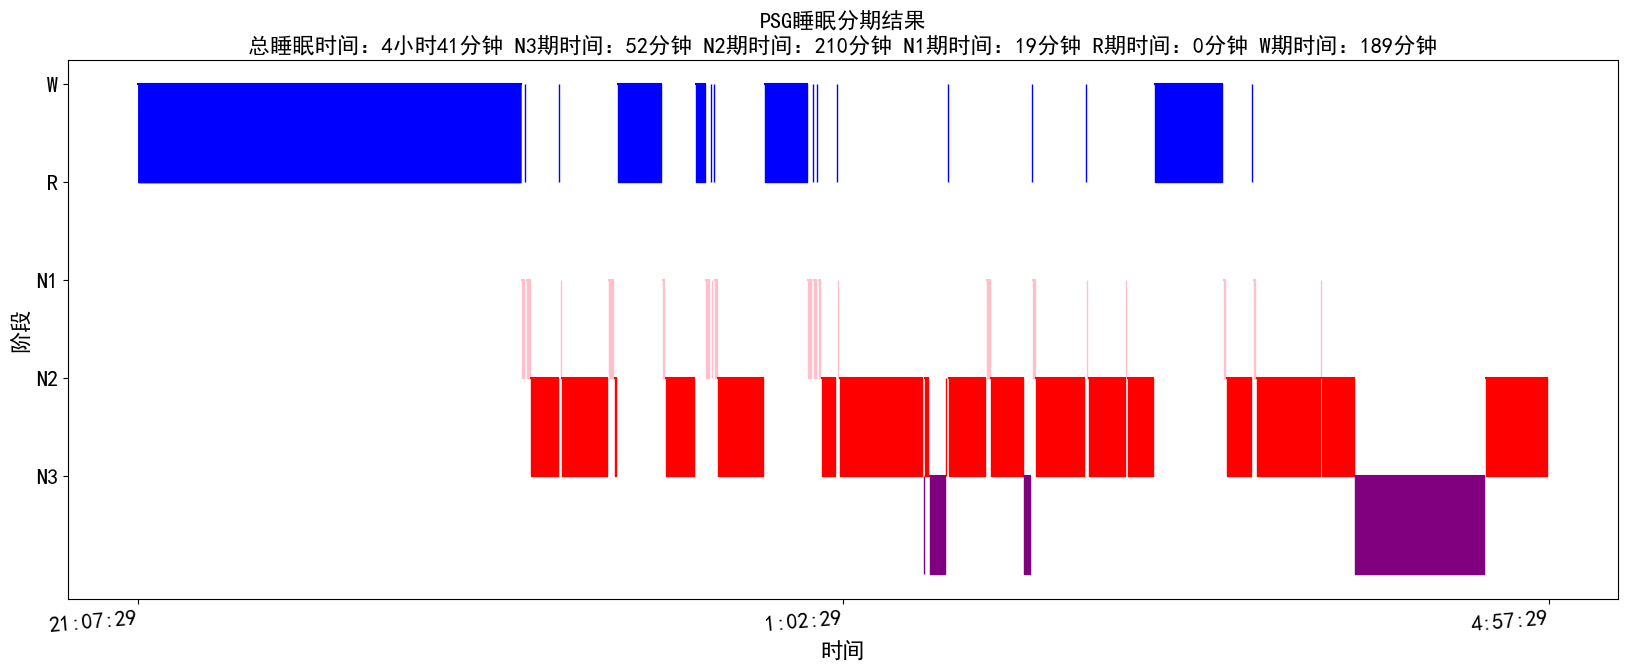

In [11]:
if __name__ == "__main__":
    main()